##### Download, normalize and split vol cube data into train/test datasets

In [1]:
import sys
sys.path.append('../..')  # to go to the main folder of the whole project

from src.data.vol.get_vol_cube_tenors_strikes_dates import get_vol_cube_tenors_strikes_dates
data, uniq_opt_tenors, uniq_swap_tenors, uniq_strikes, dates = get_vol_cube_tenors_strikes_dates()

# Normalize data
from src.data.vol.normalizer import Normalizer
normalizer = Normalizer()
data_norm = normalizer.normalize(data)

# Split train and test datasets
seed = 0 # other seeds provides the same result
from src.utils.get_train_test_datasets import get_train_test_datasets
data_norm_train, dates_train, data_norm_test, dates_test = get_train_test_datasets(data_norm,
                                                                                   dates,
                                                                                    seed=seed,
                                                                                    train_ratio=0.8)
data_train = normalizer.denormalize(data_norm_train)
data_test = normalizer.denormalize(data_norm_test)

##### Load the saved model and its history from the file

In [2]:
from src.utils.load_model_and_history import load_model_and_history

NAME = 'vol_cube_vae_van_2latd_400_200_200_100_3000ep_bat16_2e-06_seed0'
vae, history = load_model_and_history(NAME,
                                      data_type='vol')

c:\Users\alexi\Documents\All\ETH_UZH\MasterThesis\_MT_Vol_cube\code_my\autoencoder_library\venv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


##### Let's try to find 1 test dataset vol cube around many newly generated vol cubes

1 test dataset vol cube with the highest vol among all test dataset

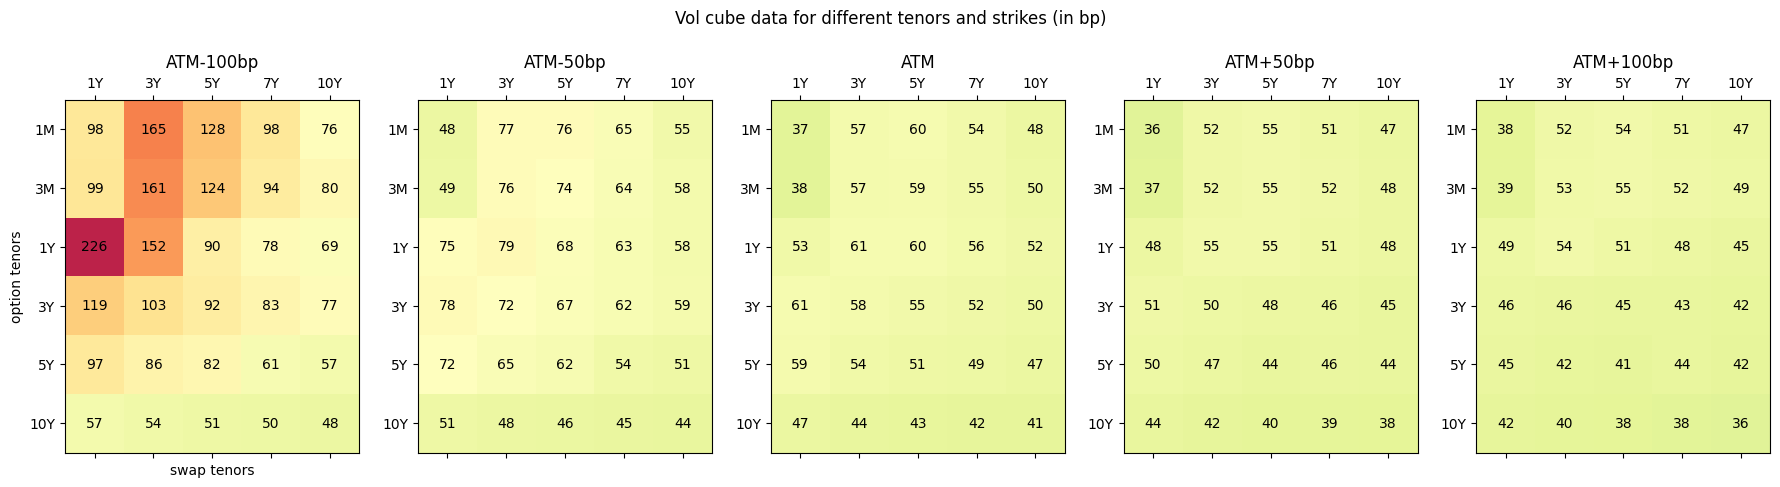

In [3]:
from src.visualization.vol.vol_cube_grids import vol_cube_grids
strikes = ['ATM-100bp', 'ATM-50bp', 'ATM', 'ATM+50bp', 'ATM+100bp']  # graphs only for these strikes

date_idx = 0
vol_cube_grids(data=data_test[date_idx],
                x_labels=uniq_swap_tenors,
                y_labels=uniq_opt_tenors,
                uniq_strikes=uniq_strikes,
                strikes=strikes)

Generate N vol cubes

In [4]:
import numpy as np
from src.visualization.vol.vol_cube_grids import vol_cube_grids
strikes = ['ATM-100bp', 'ATM-50bp', 'ATM', 'ATM+50bp', 'ATM+100bp']  # graphs only for these strikes

N = 1_000

latent_space_dim = vae.encoder.predict(x=data_norm_test, verbose=0)[0].shape[1]
mean = np.zeros(latent_space_dim)
cov = np.eye(latent_space_dim) * 4
np.random.seed(0)
z_initial = np.random.multivariate_normal(mean, cov, N)

gen_vol_cubes = normalizer.denormalize(vae.decoder.predict(np.array(z_initial), verbose=0))

Find generated vol cube that fits our test dataset the best way in terms of mse error

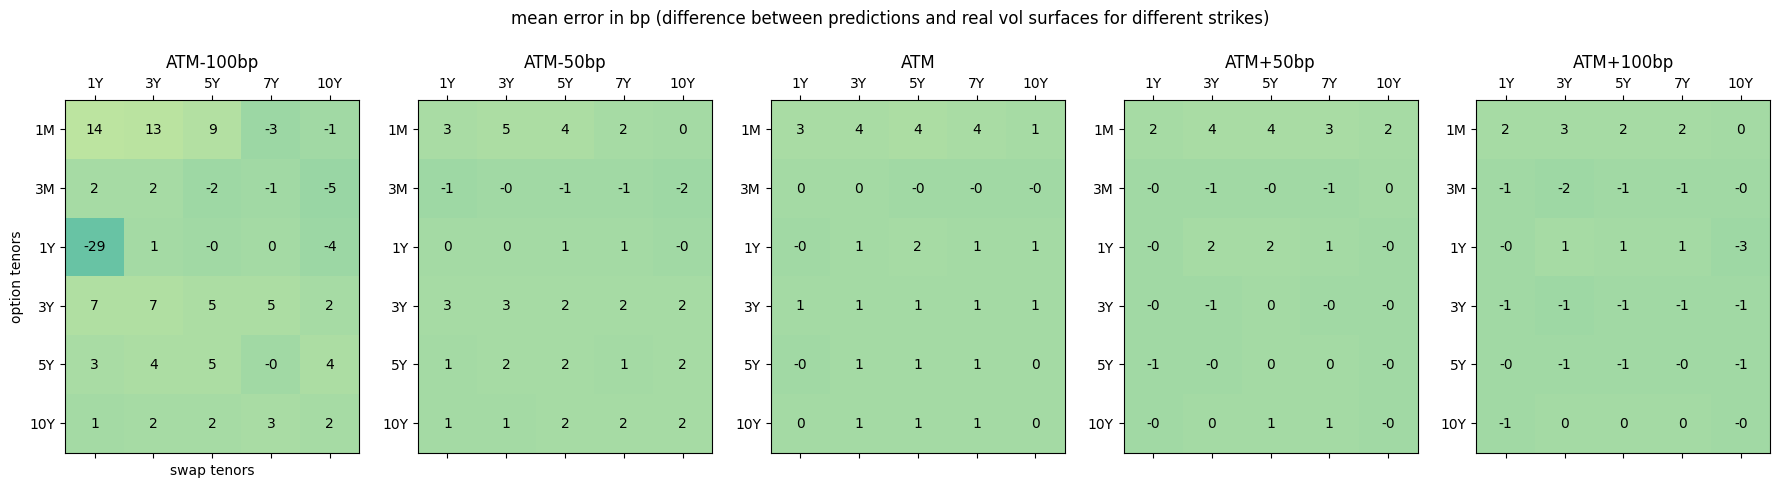

In [5]:
mse_optimal = float('inf')  # largest possible value

for i in range(N):
    diff = data_test[date_idx] - gen_vol_cubes[i]
    mse = (diff**2).mean()
    if mse < mse_optimal:
        id_best = i
        mse_optimal = mse

from src.visualization.vol.error_vol_cube_grids import error_vol_cube_grids
error_vol_cube_grids(predictions=np.expand_dims(gen_vol_cubes[id_best],0),  # not normalized
                     data=np.expand_dims(data_test[date_idx],0),          # not normalized
                     x_labels=uniq_swap_tenors,
                     y_labels=uniq_opt_tenors,
                     uniq_strikes=uniq_strikes, 
                     strikes=strikes, 
                     error_type='mean',
                     save_name=NAME
                     )